# Comparing global XXL-100-GC $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements to literature

This notebook measures global temperatures and luminosities for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec
from xga.sourcetools.match import simple_xmm_match

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

## Reading in XXL-100-GC sample file and declaring XGA ClusterSample

This subsection involves reading in the sample file of the XXL-100-GC sample (described in [the sample properties notebook](sample_properties.ipynb)), then setting up an XGA ClusterSample instance (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects).

### Sample file

First off, we read in our sample csv file - this has all the relevant XXL information that we will need:

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

### Setting up the XGA sample

We impose a cleaning step on the sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7, back_inn_rad_factor=3.33, 
                         back_out_rad_factor=5)

Generating products of type(s) expmap: 100%|██████████████████████████████████| 89/89 [00:04<00:00, 21.80it/s]


### Removing a troublesome cluster

This cluster causes issues during spectral generation, specifically during the backscale calculation step, likely as a result of the background annulus chosen for our re-analysis. We could manually adjust the background annulus, but seeing as we're using XXL-100-GC purely for comparisons, and we have plenty of clusters to compare, we simply remove it from the sample:

In [4]:
del xxl_srcs['XLSSC-11']

### Cluster excluded from the ClusterSample

One of the XXL-100-GC clusters has not been included in the defined cluster sample, despite having XMM data (a given, as the XXL clusters were selected from XMM obserations). We can access the reason why by looking at the failed reasons property of the sample:

In [5]:
xxl_srcs.failed_reasons

{'XLSSC-527': 'Failed ObsClean'}

This essentially means that the cleaning step, where we select only those observations which have more than 70% of the cluster $R_{500}$ on them, has not left any observations. We can see why by declaring an individual galaxy cluster instance for this particular cluster; it lies at the intersection of three observations, and thus none of the observation fulfill the coverage requirements.

We could adjust the required fraction of $R_{500}$, but that would be inconsistent with the rest of the analyses, and we have plenty of galaxy clusters in our validation samples, so we shall just exclude this cluster:

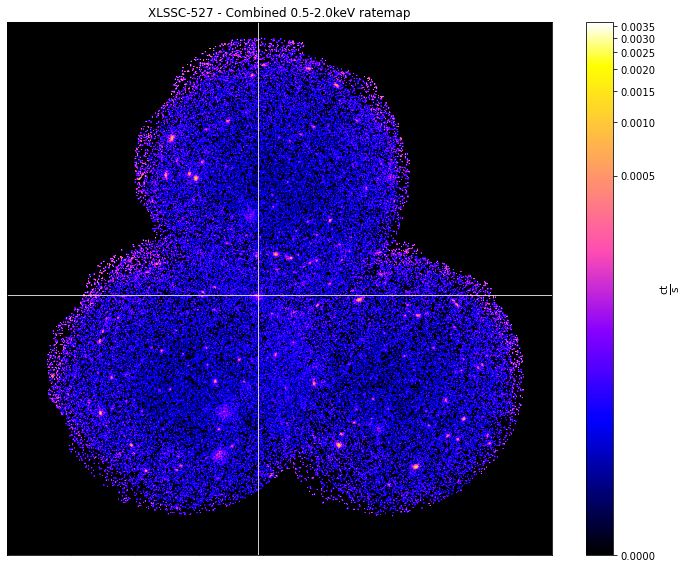

In [6]:
rel_row = xxlgc100[xxlgc100['name'] == 'XLSSC-527'].iloc[0]
xlssc527 = GalaxyCluster(rel_row['ra'], rel_row['dec'], rel_row['z'], rel_row['name'], 
                         r500=Quantity(rel_row['r500MT'], 'Mpc'), cosmology=xxl_cosmo, load_fits=True, 
                         use_peak=False, clean_obs=False, back_inn_rad_factor=3.33, back_out_rad_factor=5)
xlssc527.get_combined_ratemaps().view(xlssc527.ra_dec)

## Measuring spectral properties within 300kpc aperture

We use this command to generate and fit spectra within a 300kpc aperture, centered on the user defined coordinate:

In [7]:
single_temp_apec(xxl_srcs, Quantity(300, 'kpc'), lo_en=Quantity(0.4, 'keV'), hi_en=Quantity(7.0, 'keV'), 
                 timeout=timeout, one_rmf=False)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 97/97 [04:29<00:00,  2.78s/it]


## Reading the literature values

We read in the literature values for the declared sources, using the name of each source to find the correct row in the literature values dataframe:

In [8]:
lit_xxlgc100_tx = []
lit_xxlgc100_lx52 = []
for n in xxl_srcs.names:
    rel_row = xxlgc100[xxlgc100['name'] == n].iloc[0]
    lit_xxlgc100_tx.append(Quantity(rel_row[['T300kpc', 'T300kpc-', 'T300kpc+']], 'keV'))
    lit_xxlgc100_lx52.append(Quantity(rel_row[['L52_300kpc', 'L52_300kpc_err', 'L52_300kpc_err']]*1e+43, 'erg/s'))

lit_xxlgc100_tx = Quantity(lit_xxlgc100_tx)
lit_xxlgc100_lx52 = Quantity(lit_xxlgc100_lx52)

## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the XGA sample

We must extract and judge the quality of the temperature and luminosity measurements that we have made for the XXL-100-GC sample, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

In [9]:
xxl_tx = xxl_srcs.Tx(Quantity(300, 'kpc'), quality_checks=False)
xxl_lx = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                     hi_en=Quantity(2.0, 'keV'))
xxl_lxbol = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                     hi_en=Quantity(100.0, 'keV'))

In [10]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(xxl_tx[:, 0]).sum(), 
                                                                  t=len(xxl_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(xxl_lx[:, 0]).sum(), 
                                                                    t=len(xxl_lx)))

97 out of 97 XGA Tx measurements were successful
97 out of 97 XGA Lx52 measurements were successful


## Direct comparisons between original XXL-100-GC and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

We directly compare temperatures measured within 300 kpc and luminosities (soft band) between the XXL-100-GC results and XGA.

### $T_{\rm{X}, 300kpc}$ and $L^{\rm{0.5-2.0}}_{\rm{X}, 300kpc}$

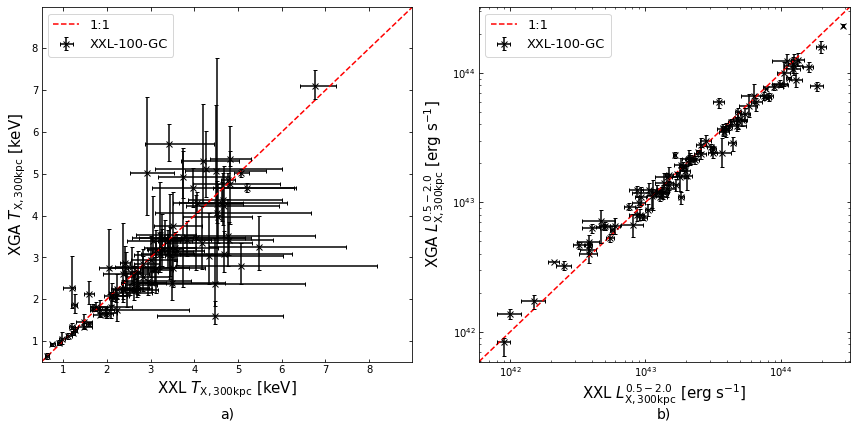

In [11]:
direct_comparison_plot([lit_xxlgc100_tx, lit_xxlgc100_lx52], [xxl_tx, xxl_lx], 
                       [r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
                        r"XXL $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 300kpc}}$ [keV]", 
                        r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]"],
                       r"XXL-100-GC", (12, 6), ['linear', 'log'], ['linear', 'log'])

### $T_{\rm{X}, 300kpc}$ by itself

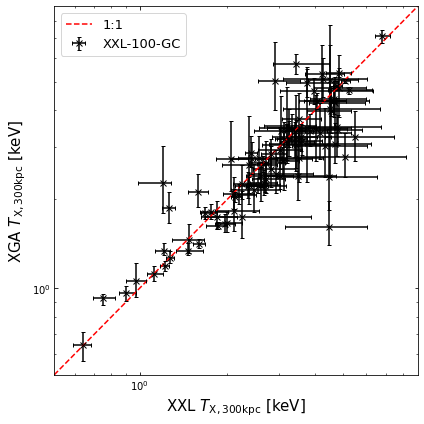

In [12]:
direct_comparison_plot(lit_xxlgc100_tx, xxl_tx, r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
                       r"XGA $T_{\rm{X, 300kpc}}$ [keV]", r"XXL-100-GC", (6, 6), ['log'], ['log'], 
                       savepath='../../outputs/figures/xxl_tx300kpc_comp.pdf')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1119.34it/s]


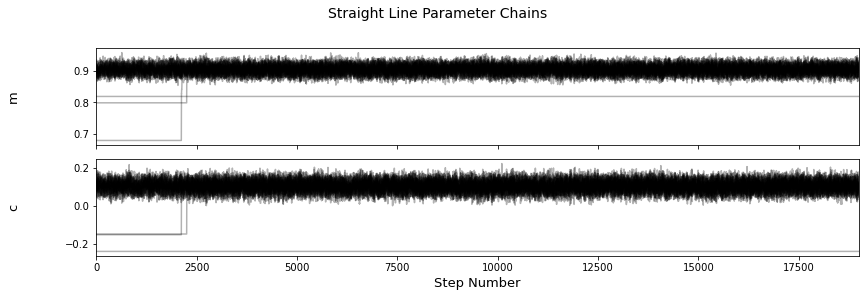

Removed no burn in


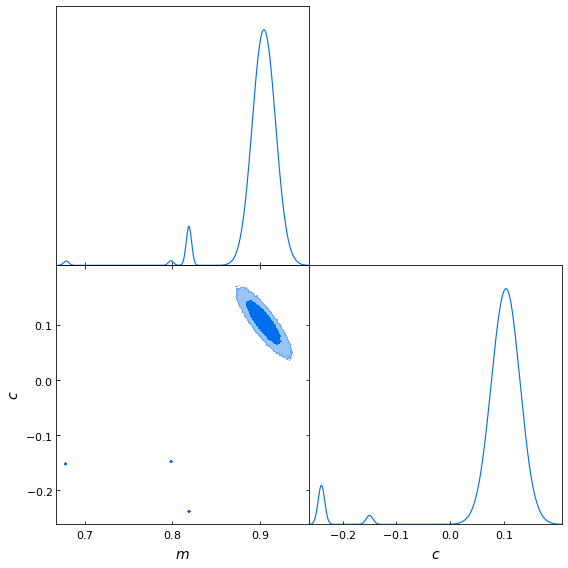

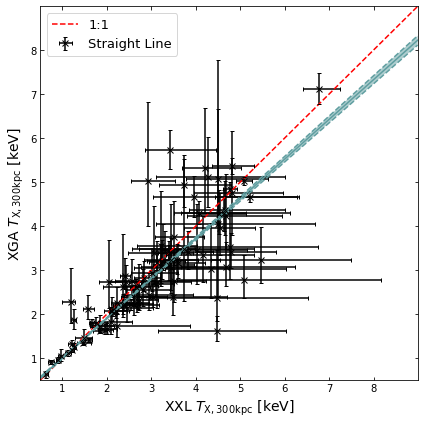

m=0.903 +0.014 -0.015 [1sig]
c=0.101 +0.028 -0.031 [1sig]


In [13]:
fit_comp(lit_xxlgc100_tx, xxl_tx, [[0, 100], [0, 5]], r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
         r"XGA $T_{\rm{X, 300kpc}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:20<00:00, 970.16it/s]


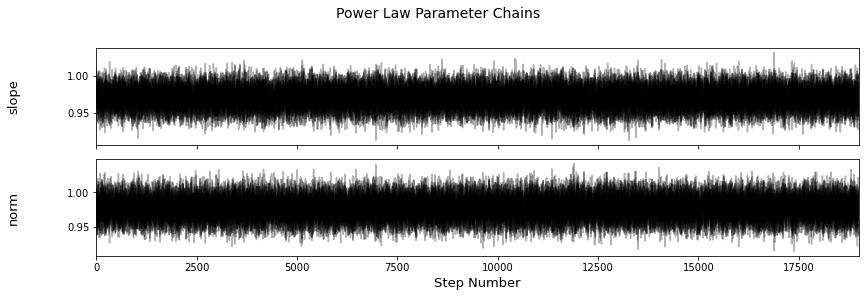

Removed no burn in


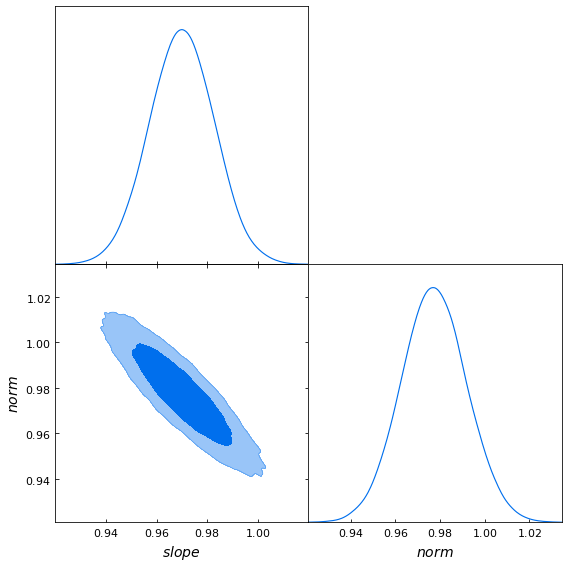

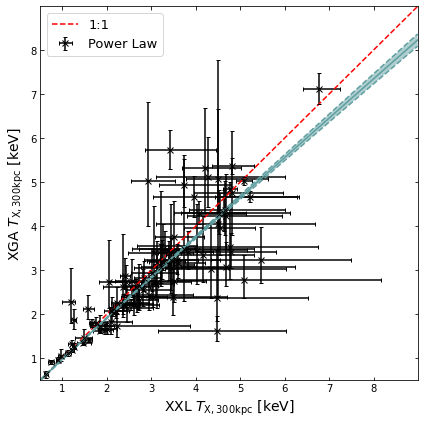

slope=0.97 +0.013 -0.013 [1sig]
norm=0.977 +0.015 -0.015 [1sig]


In [14]:
fit_comp(lit_xxlgc100_tx, xxl_tx, [[0, 100], [0, 5]], r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
         r"XGA $T_{\rm{X, 300kpc}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=False, view_corner=True)

## Outputting XGA measured values as a catalogue

The values we re-measure will be saved to disk as a csv:

In [15]:
xga_xxl_out = pd.DataFrame(np.array([xxl_srcs.names.T, xxl_tx[:, 0].value, xxl_tx[:, 1].value, 
                                      xxl_tx[:, 2].value, xxl_lx[:, 0].value, xxl_lx[:, 1].value, 
                                      xxl_lx[:, 2].value, xxl_lxbol[:, 0].value, xxl_lxbol[:, 1].value, 
                                      xxl_lxbol[:, 2].value]).T, 
                            columns=['name', 'Tx_300kpc', 'Tx_300kpc-', 'Tx_300kpc+', 'Lx52_300kpc', 'Lx52_300kpc-', 
                                     'Lx52_300kpc+', 'Lxbol_300kpc', 'Lxbol_300kpc-', 'Lxbol_300kpc+'])

xga_xxl_out.to_csv("../../outputs/results/xxl_300kpc_txlx.csv", index=False)

xga_xxl_out

,name,Tx_300kpc,Tx_300kpc-,Tx_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,Lxbol_300kpc,Lxbol_300kpc-,Lxbol_300kpc+
0,XLSSC-94,4.23982,0.757080073,0.9460176770000004,1.5800928110000002e+44,1.463867758341313e+43,1.775443855873111e+43,4.694600586e+44,6.72638686339799e+43,4.42661151036806e+43
1,XLSSC-96,3.23895,0.5400230079999999,0.744324599,3.70791534e+43,4.373890162268481e+42,3.14792087159134e+42,9.777226076000001e+43,1.310422669608205e+43,9.636063187920361e+42
2,XLSSC-102,3.54698,0.8328183789999999,1.2558073149999998,1.2665010930000001e+44,1.4513678988568542e+43,1.55918173698864e+43,3.431493769e+44,4.622051490157963e+43,4.791957804628782e+43
3,XLSSC-106,3.44384,0.3607417869999998,0.4441262860000003,2.5796317270000006e+43,1.13836623849398e+42,1.4948830089098e+42,7.038343942000001e+43,6.049426317534971e+42,4.35003110594501e+42
4,XLSSC-107,2.64447,0.3781314090000003,0.5011564709999998,3.5196899770000005e+43,2.87707197157136e+42,3.85914402058632e+42,8.537257218e+43,1.128644349447026e+43,8.677089148609972e+42
...,...,...,...,...,...,...,...,...,...,...
92,XLSSC-540,2.69518,0.2756745020000002,0.3174329029999998,3.8121175480000006e+43,2.0583505242071002e+42,1.7435246741924202e+42,9.329326613e+43,6.975082278174212e+42,6.23772386171353e+42
93,XLSSC-539,2.27604,0.484597498,0.763261988,4.9169676070000005e+42,3.2643356353532002e+41,7.191553914088501e+41,1.1486299460000002e+43,1.24264510953052e+42,2.38903698301699e+42
94,XLSSC-509,3.35178,0.6213768170000002,0.8900113109999999,5.939652707000001e+43,8.616632472513911e+42,5.14380223832968e+42,1.585025921e+44,2.5573953090546885e+43,9.656387116744751e+42
95,XLSSC-510,2.23399,0.2576351489999999,0.3419496680000002,2.1228248810000003e+43,1.5448383195822302e+42,1.7670861045482702e+42,4.840276659e+43,4.4223387306860503e+42,3.22471406230224e+42
